In [4]:
import numpy as np
import pandas as pd

# Load your train and test data directly
X_train = pd.read_csv('Project datasets/Sample files/train_inputs_50.csv', header=None).values
y_train = pd.read_csv('Project datasets/Sample files/train_outputs_50.csv', header=None).values
X_test = pd.read_csv('Project datasets/Sample files/test_inputs_50.csv', header=None).values
y_test = pd.read_csv('Project datasets/Sample files/test_outputs_50.csv', header=None).values

# Expand the dimensions to add a channel dimension, making them (samples, timesteps, channels)
X_train = np.expand_dims(X_train, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

# Verify the shapes of the arrays
print("X_train shape:", X_train.shape)  # Expected: (samples, timesteps, 1)
print("y_train shape:", y_train.shape)  # Expected: (samples, timesteps, 1)
print("X_test shape:", X_test.shape)    # Expected: (samples, timesteps, 1)
print("y_test shape:", y_test.shape)    # Expected: (samples, timesteps, 1)

X_train shape: (50, 500, 1)
y_train shape: (50, 500, 1)
X_test shape: (50, 500, 1)
y_test shape: (50, 500, 1)


In [5]:
from tensorflow.keras.layers import Input, Dense, Conv1D, Add, GlobalAveragePooling1D, Reshape, Multiply
from tensorflow.keras.models import Model

def residual_channel_attention_block(x, filters=64, kernel_size=3, reduction_ratio=16):
    # Residual Conv Layers
    conv = Conv1D(filters, kernel_size, padding='same', activation='relu')(x)
    conv = Conv1D(filters, kernel_size, padding='same')(conv)
    
    # Channel Attention Mechanism
    gap = GlobalAveragePooling1D()(conv)
    fc1 = Dense(filters // reduction_ratio, activation='relu')(gap)
    fc2 = Dense(filters, activation='sigmoid')(fc1)
    scale = Multiply()([conv, Reshape((1, filters))(fc2)])
    
    # Add Residual Connection
    out = Add()([scale, x])
    return out

def build_rcan(input_shape, num_blocks=4, filters=64, kernel_size=3):
    input_layer = Input(shape=input_shape)
    
    # Initial Conv Layer
    x = Conv1D(filters, kernel_size, padding='same', activation='relu')(input_layer)
    
    # Stack Residual Channel Attention Blocks
    for _ in range(num_blocks):
        x = residual_channel_attention_block(x, filters=filters, kernel_size=kernel_size)
    
    # Output Conv Layer
    output_layer = Conv1D(1, kernel_size, padding='same', activation='linear')(x)
    
    # Build Model
    rcan = Model(inputs=input_layer, outputs=output_layer)
    rcan.compile(optimizer='adam', loss='mean_squared_error')
    rcan.summary()
    return rcan


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 500, 64)      256         ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 500, 64)      12352       ['conv1d[0][0]']                 
                                                                                                  
 conv1d_2 (Conv1D)              (None, 500, 64)      12352       ['conv1d_1[0][0]']               
                                                                                              

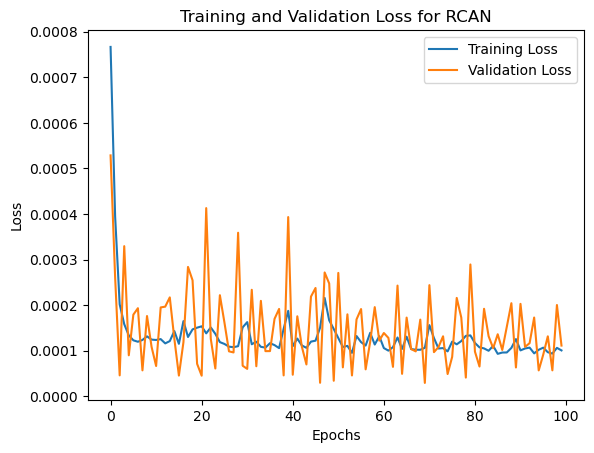

2/2 [==============================] - 3s 169ms/step


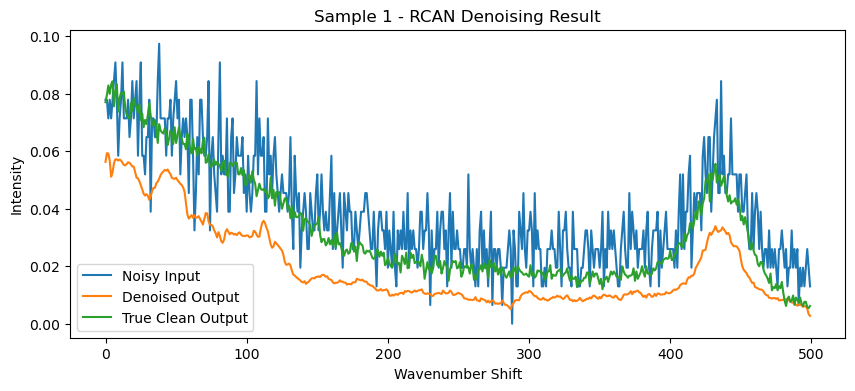

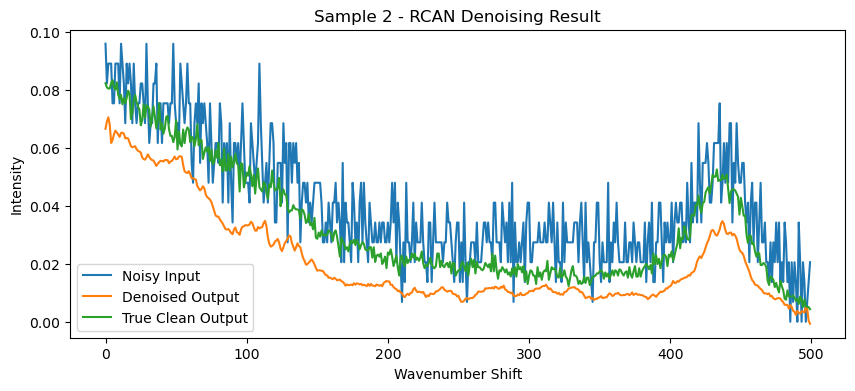

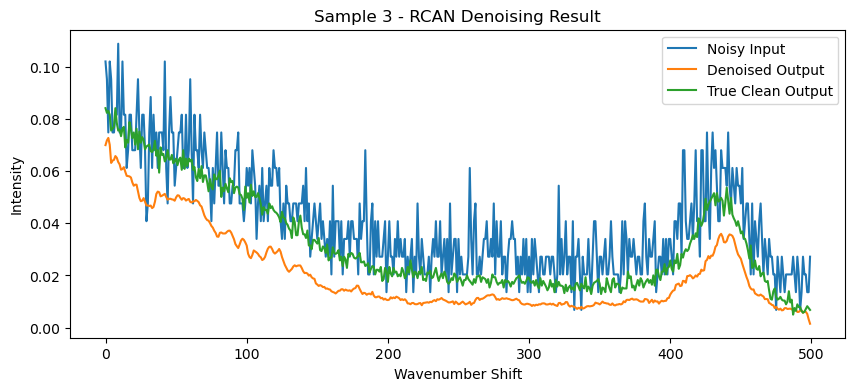

In [6]:
# Build the RCAN model
input_shape = X_train.shape[1:]  # (timesteps, channels)
rcan_model = build_rcan(input_shape, num_blocks=4, filters=64, kernel_size=3)

# Train the model
history = rcan_model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_test, y_test))

# Plot training and validation loss over epochs
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss for RCAN')
plt.show()

# Predict on the test set and visualize
predicted_output = rcan_model.predict(X_test)

# Visualize original noisy, denoised, and true clean spectra for a few samples
for i in range(3):  # Plot three samples
    plt.figure(figsize=(10, 4))
    plt.plot(X_test[i].flatten(), label='Noisy Input')
    plt.plot(predicted_output[i].flatten(), label='Denoised Output')
    plt.plot(y_test[i].flatten(), label='True Clean Output')
    plt.xlabel('Wavenumber Shift')
    plt.ylabel('Intensity')
    plt.legend()
    plt.title(f'Sample {i+1} - RCAN Denoising Result')
    plt.show()


In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from skimage.metrics import structural_similarity as ssim
import math

In [8]:
# Flatten the arrays for comparison
y_true_flat = y_test.flatten()
y_pred_flat = predicted_output.flatten()

# RMSE
rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# MAE
mae = mean_absolute_error(y_true_flat, y_pred_flat)
print(f"Mean Absolute Error (MAE): {mae}")

Root Mean Squared Error (RMSE): 0.010542593305582507
Mean Absolute Error (MAE): 0.00916892443738763


In [9]:
# SNR Calculation
signal_power = np.sum(y_test ** 2)
noise_power = np.sum((y_test - predicted_output) ** 2)
snr = 10 * np.log10(signal_power / noise_power)
print(f"Signal-to-Noise Ratio (SNR): {snr} dB")

Signal-to-Noise Ratio (SNR): 11.5191950348385 dB


In [10]:
# PSNR Calculation
peak_signal = np.max(y_test)  # Maximum intensity in the clean spectra
mse = mean_squared_error(y_true_flat, y_pred_flat)
psnr = 10 * math.log10(peak_signal ** 2 / mse)
print(f"Peak Signal-to-Noise Ratio (PSNR): {psnr} dB")

Peak Signal-to-Noise Ratio (PSNR): 18.773648631440842 dB


In [11]:
# Calculate SSIM for each spectrum and take the mean
ssim_values = [ssim(y_test[i].flatten(), predicted_output[i].flatten()) for i in range(len(y_test))]
mean_ssim = np.mean(ssim_values)
print(f"Mean Structural Similarity Index (SSIM): {mean_ssim}")

Mean Structural Similarity Index (SSIM): 0.9462058048537656


c:\Users\91892\anaconda3\lib\site-packages\skimage\_shared\utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


In [12]:
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Signal-to-Noise Ratio (SNR): {snr} dB")
print(f"Peak Signal-to-Noise Ratio (PSNR): {psnr} dB")
print(f"Mean Structural Similarity Index (SSIM): {mean_ssim}")

Root Mean Squared Error (RMSE): 0.010542593305582507
Mean Absolute Error (MAE): 0.00916892443738763
Signal-to-Noise Ratio (SNR): 11.5191950348385 dB
Peak Signal-to-Noise Ratio (PSNR): 18.773648631440842 dB
Mean Structural Similarity Index (SSIM): 0.9462058048537656
